Mounted at /content/drive
Found 11 .tif files to process
Processing 3 files

Processing: denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq001_Golgi_regional_tophat.tif
  Image shape: (1024, 1024)
  Detected single-channel image, using as is
  Applying Gaussian blur...
  Performing Li thresholding...
  Original threshold value: 0.1072 (top 94.66% of pixel values)
  5% lower threshold: 0.0965 (top 94.42% of pixel values)
  10% lower threshold: 0.0858 (top 94.15% of pixel values)
  Elements detected with original threshold: 174
  Elements detected with 5% lower threshold: 186 (6.9% change)
  Elements detected with 10% lower threshold: 191 (9.8% change)

Processing: denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq002_Golgi_regional_tophat.tif
  Image shape: (1024, 1024)
  Detected single-channel image, using as is
  Applying Gaussian blur...
  Performing Li thresholding...
  Original threshold value: 0.1088 (top 94.37% of pixel values)
  5% lower threshold: 0.0979 (top 94.12% of pixel values)
  10% low

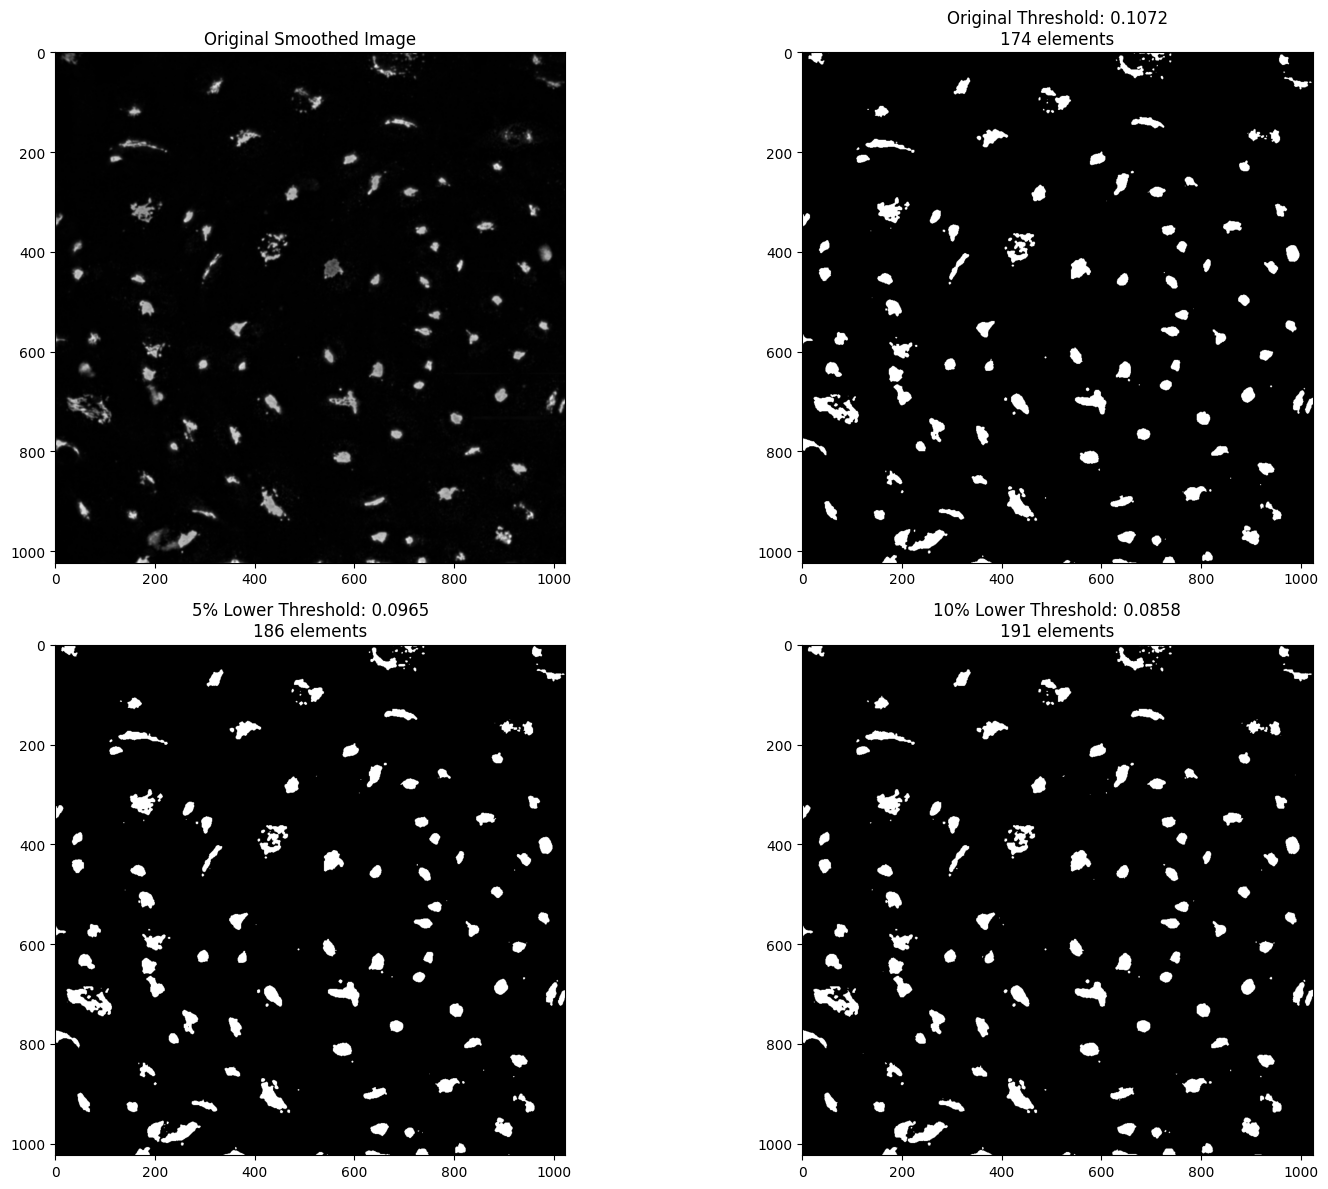

In [ ]:
import numpy as np
import tifffile
from scipy import ndimage
from skimage.filters import gaussian
from skimage.filters import threshold_li
from skimage.measure import label
import os
import glob
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define input path - using your original path
input_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/Static-x40/Golgi/tophat'

# Find all .tif files in the input directory
input_files = glob.glob(os.path.join(input_dir, '*.tif'))
print(f"Found {len(input_files)} .tif files to process")

# Process only the first few files (to avoid long processing time)
max_files_to_process = 3
input_files = input_files[:max_files_to_process]
print(f"Processing {len(input_files)} files")

# Lists to store results
thresholds = []
percentile_5_percent = []
percentile_10_percent = []
element_counts = []
element_counts_5_percent = []
element_counts_10_percent = []

# Process each file
for input_file in input_files:
    # Get base filename for output
    filename = os.path.basename(input_file)
    print(f"\nProcessing: {filename}")

    # Load the image
    img = tifffile.imread(input_file)
    print(f"  Image shape: {img.shape}")

    # Extract Golgi channel based on image format
    if len(img.shape) == 2:
        # Single channel image (already Golgi)
        print("  Detected single-channel image, using as is")
        golgi_channel = img
    elif len(img.shape) == 3 and img.shape[0] == 3:
        # Format is (C, H, W)
        print("  Detected format: (C, H, W)")
        golgi_channel = img[2]  # Third channel
    elif len(img.shape) == 3 and img.shape[2] == 3:
        # Format is (H, W, C)
        print("  Detected format: (H, W, C)")
        golgi_channel = img[:, :, 2]  # Third channel
    else:
        print(f"  Unexpected image shape: {img.shape}. Using first channel/plane.")
        if len(img.shape) == 3:
            golgi_channel = img[0] if img.shape[0] < img.shape[1] else img[:, :, 0]
        else:
            golgi_channel = img

    # Apply Gaussian blur to reduce noise
    print("  Applying Gaussian blur...")
    golgi_smoothed = gaussian(golgi_channel, sigma=1)

    # Apply Li thresholding
    print("  Performing Li thresholding...")
    orig_thresh = threshold_li(golgi_smoothed)
    binary = golgi_smoothed > orig_thresh

    # Calculate pixel value percentiles
    flat_values = golgi_smoothed.flatten()
    sorted_values = np.sort(flat_values)

    # Calculate thresholds for 5% and 10% reduction
    thresh_5_percent = orig_thresh * 0.90
    thresh_10_percent = orig_thresh * 0.80

    # Find percentiles these thresholds represent
    percentile_orig = 100 * (1 - np.mean(binary))
    percentile_5 = 100 * (1 - np.mean(golgi_smoothed > thresh_5_percent))
    percentile_10 = 100 * (1 - np.mean(golgi_smoothed > thresh_10_percent))

    # Apply different thresholds and count elements
    binary_orig = golgi_smoothed > orig_thresh
    binary_5_percent = golgi_smoothed > thresh_5_percent
    binary_10_percent = golgi_smoothed > thresh_10_percent

    # Label connected components for each threshold
    labels_orig = label(binary_orig)
    labels_5_percent = label(binary_5_percent)
    labels_10_percent = label(binary_10_percent)

    # Count unique elements (subtract 1 to exclude background)
    count_orig = len(np.unique(labels_orig)) - 1
    count_5_percent = len(np.unique(labels_5_percent)) - 1
    count_10_percent = len(np.unique(labels_10_percent)) - 1

    # Store results
    thresholds.append(orig_thresh)
    percentile_5_percent.append(percentile_5)
    percentile_10_percent.append(percentile_10)
    element_counts.append(count_orig)
    element_counts_5_percent.append(count_5_percent)
    element_counts_10_percent.append(count_10_percent)

    # Print detailed information
    print(f"  Original threshold value: {orig_thresh:.4f} (top {percentile_orig:.2f}% of pixel values)")
    print(f"  5% lower threshold: {thresh_5_percent:.4f} (top {percentile_5:.2f}% of pixel values)")
    print(f"  10% lower threshold: {thresh_10_percent:.4f} (top {percentile_10:.2f}% of pixel values)")
    print(f"  Elements detected with original threshold: {count_orig}")
    print(f"  Elements detected with 5% lower threshold: {count_5_percent} ({(count_5_percent-count_orig)/count_orig*100:.1f}% change)")
    print(f"  Elements detected with 10% lower threshold: {count_10_percent} ({(count_10_percent-count_orig)/count_orig*100:.1f}% change)")

# Calculate averages
avg_orig_percentile = np.mean([100 - p5 for p5 in percentile_5_percent]) + 5  # Estimate original percentile
avg_percentile_5 = np.mean(percentile_5_percent)
avg_percentile_10 = np.mean(percentile_10_percent)
avg_count_change_5 = np.mean([(e5 - e0)/e0*100 for e0, e5 in zip(element_counts, element_counts_5_percent)])
avg_count_change_10 = np.mean([(e10 - e0)/e0*100 for e0, e10 in zip(element_counts, element_counts_10_percent)])

print("\nSummary:")
print(f"Original threshold (Li method) selects approximately the top {avg_orig_percentile:.2f}% of pixel values")
print(f"Reducing threshold by 5% selects approximately the top {100-avg_percentile_5:.2f}% of pixel values")
print(f"Reducing threshold by 10% selects approximately the top {100-avg_percentile_10:.2f}% of pixel values")
print(f"Average increase in detected elements with 5% lower threshold: {avg_count_change_5:.1f}%")
print(f"Average increase in detected elements with 10% lower threshold: {avg_count_change_10:.1f}%")

# Create a visualization for one sample image (the first one)
if len(input_files) > 0:
    # Reload the first image to visualize results
    img = tifffile.imread(input_files[0])

    # Extract Golgi channel
    if len(img.shape) == 2:
        golgi_channel = img
    elif len(img.shape) == 3 and img.shape[0] == 3:
        golgi_channel = img[2]
    elif len(img.shape) == 3 and img.shape[2] == 3:
        golgi_channel = img[:, :, 2]
    else:
        if len(img.shape) == 3:
            golgi_channel = img[0] if img.shape[0] < img.shape[1] else img[:, :, 0]
        else:
            golgi_channel = img

    # Apply Gaussian blur
    golgi_smoothed = gaussian(golgi_channel, sigma=1)

    # Apply thresholds
    thresh = thresholds[0]
    thresh_5 = thresh * 0.90
    thresh_10 = thresh * 0.80

    binary_orig = golgi_smoothed > thresh
    binary_5 = golgi_smoothed > thresh_5
    binary_10 = golgi_smoothed > thresh_10

    # Create labeled images
    labels_orig = label(binary_orig)
    labels_5 = label(binary_5)
    labels_10 = label(binary_10)

    # Create visualization
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.imshow(golgi_smoothed, cmap='gray')
    plt.title('Original Smoothed Image')

    plt.subplot(2, 2, 2)
    plt.imshow(labels_orig > 0, cmap='gray')
    plt.title(f'Original Threshold: {thresh:.4f}\n{element_counts[0]} elements')

    plt.subplot(2, 2, 3)
    plt.imshow(labels_5 > 0, cmap='gray')
    plt.title(f'5% Lower Threshold: {thresh_5:.4f}\n{element_counts_5_percent[0]} elements')

    plt.subplot(2, 2, 4)
    plt.imshow(labels_10 > 0, cmap='gray')
    plt.title(f'10% Lower Threshold: {thresh_10:.4f}\n{element_counts_10_percent[0]} elements')

    plt.tight_layout()


In [1]:
import numpy as np
import tifffile
from scipy import ndimage
from skimage.filters import gaussian
from skimage.filters import threshold_li  # Changed from threshold_otsu to threshold_li
from skimage.measure import label
import os
import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define input and output paths
input_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/Static-x20/Golgi/tophat'
output_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-x20/Golgi'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define threshold reduction percentage
threshold_reduction = 0.80  # This means we'll use 85% of the original threshold value (15% reduction)

# Find all .tif files in the input directory
input_files = glob.glob(os.path.join(input_dir, '*.tif'))
print(f"Found {len(input_files)} .tif files to process")

# Process each file
for input_file in input_files:
    # Get base filename for output
    filename = os.path.basename(input_file)
    base_name = os.path.splitext(filename)[0]

    print(f"Processing: {filename}")

    # Load the image
    img = tifffile.imread(input_file)
    print(f"  Image shape: {img.shape}")

    # Extract Golgi channel based on image format
    if len(img.shape) == 2:
        # Single channel image (already Golgi)
        print("  Detected single-channel image, using as is")
        golgi_channel = img
    elif len(img.shape) == 3 and img.shape[0] == 3:
        # Format is (C, H, W)
        print("  Detected format: (C, H, W)")
        golgi_channel = img[2]  # Third channel
    elif len(img.shape) == 3 and img.shape[2] == 3:
        # Format is (H, W, C)
        print("  Detected format: (H, W, C)")
        golgi_channel = img[:, :, 2]  # Third channel
    else:
        print(f"  Unexpected image shape: {img.shape}. Using first channel/plane.")
        if len(img.shape) == 3:
            golgi_channel = img[0] if img.shape[0] < img.shape[1] else img[:, :, 0]
        else:
            golgi_channel = img

    # Apply Gaussian blur to reduce noise
    print("  Applying Gaussian blur...")
    golgi_smoothed = gaussian(golgi_channel, sigma=1)

    # Apply Li thresholding with reduced threshold
    print("  Performing Li thresholding...")
    original_thresh = threshold_li(golgi_smoothed)
    thresh = original_thresh * threshold_reduction  # Apply the 15% reduction
    binary = golgi_smoothed > thresh

    # Label connected components
    print("  Labeling connected components...")
    labels = label(binary)  # Directly label the binary image without opening/closing
    print(f"  Segmentation complete. Found {len(np.unique(labels))-1} objects")

    # Save the labeled image (main output)
    labels_output = os.path.join(output_dir, f"{base_name}_golgi_labels.tif")
    tifffile.imwrite(labels_output, labels.astype(np.uint32))
    print(f"  Saved labeled image to {labels_output}")

    # Print some statistics about the segmentation
    print(f"  Original threshold value: {original_thresh}")
    print(f"  Reduced threshold (15% lower): {thresh}")
    print(f"  Found {len(np.unique(labels))-1} Golgi objects")
    print(f"  Processing complete for {filename}\n")

print("All processing complete!")

Mounted at /content/drive
Found 23 .tif files to process
Processing: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_Golgi_regional_tophat.tif
  Image shape: (1024, 1024)
  Detected single-channel image, using as is
  Applying Gaussian blur...
  Performing Li thresholding...
  Labeling connected components...
  Segmentation complete. Found 407 objects
  Saved labeled image to /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-x20/Golgi/denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_Golgi_regional_tophat_golgi_labels.tif
  Original threshold value: 0.048855943144927506
  Reduced threshold (15% lower): 0.03908475451594201
  Found 407 Golgi objects
  Processing complete for denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_Golgi_regional_tophat.tif

Processing: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_Golgi_regional_tophat.tif
  Image shape: (1024, 1024)
  Detected single-channel image, using as is
  Applying Gaussian blur...
  Performing Li thresholding...
  Lab